In [4]:
# ============================================================================
# PREGUNTA 1: TWFE & EVENT-STUDY - SOLUCIÓN COMPLETA EN PYTHON
# Optimizado para Google Colab
# ============================================================================

# PASO 0: INSTALACIÓN DE PAQUETES NECESARIOS
# ============================================================================
print("Instalando paquetes necesarios...")
!pip install -q linearmodels statsmodels matplotlib seaborn pandas numpy

print("✓ Paquetes instalados correctamente\n")

# PASO 1: IMPORTAR LIBRERÍAS
# ============================================================================
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configuración de estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("="*80)
print("PREGUNTA 1: TWFE & EVENT-STUDY ANALYSIS")
print("="*80)

Instalando paquetes necesarios...
✓ Paquetes instalados correctamente

PREGUNTA 1: TWFE & EVENT-STUDY ANALYSIS


In [5]:
# ============================================================================
# PARTE A: TWFE REGRESSION
# ============================================================================
print("\n" + "="*80)
print("PARTE A: TWO-WAY FIXED EFFECTS (TWFE) REGRESSION")
print("="*80)

# Cargar datos
url = "https://raw.githubusercontent.com/LOST-STATS/LOST-STATS.github.io/master/Model_Estimation/Data/Event_Study_DiD/bacon_example.csv"
print(f"\nCargando datos desde: {url}")
df = pd.read_csv(url)
print("✓ Datos cargados exitosamente")

# Explorar datos
print("\n" + "-"*80)
print("EXPLORACIÓN INICIAL DE DATOS")
print("-"*80)
print(f"\nDimensiones del dataset: {df.shape[0]} filas × {df.shape[1]} columnas")
print(f"\nVariables disponibles: {list(df.columns)}")
print("\nPrimeras 10 filas:")
print(df.head(10))
print("\nTipos de datos:")
print(df.dtypes)
print("\nEstadísticas descriptivas:")
print(df.describe())
print("\nValores faltantes por variable:")
print(df.isnull().sum())

# CREAR VARIABLE DE TRATAMIENTO
# La variable '_nfd' indica el año en que fue tratado cada estado
# Si '_nfd' no es NaN, el estado eventualmente recibe tratamiento
print("\n" + "-"*80)
print("CREACIÓN DE VARIABLE DE TRATAMIENTO")
print("-"*80)

# Crear indicador de tratamiento: treated = 1 si _nfd no es NaN AND year >= _nfd
df['treated'] = ((df['_nfd'].notna()) & (df['year'] >= df['_nfd'])).astype(int)

print("\n✓ Variable 'treated' creada")
print("\nLógica: treated = 1 si el estado ha sido tratado en ese año")
print("        treated = 0 si el estado no ha sido tratado aún o nunca es tratado")

# Verificar variable de tratamiento
print("\nDistribución de la variable de tratamiento:")
print(df['treated'].value_counts())
print(f"\nEstados que eventualmente son tratados: {df['_nfd'].notna().sum() // df.groupby('stfips').size().iloc[0]}")
print(f"Estados nunca tratados (control): {df['_nfd'].isna().sum() // df.groupby('stfips').size().iloc[0]}")
print(f"Estados únicos: {df['stfips'].nunique()}")
print(f"Años únicos: {df['year'].nunique()}")
print(f"Rango de años: {df['year'].min()} - {df['year'].max()}")

# Mostrar ejemplos de estados tratados y no tratados
print("\nEjemplo - Estado tratado (stfips=1):")
print(df[df['stfips']==1][['stfips', 'year', '_nfd', 'post', 'treated', 'asmrs']].head(10))
print("\nEjemplo - Estado nunca tratado:")
never_treated = df[df['_nfd'].isna()]['stfips'].iloc[0]
print(df[df['stfips']==never_treated][['stfips', 'year', '_nfd', 'post', 'treated', 'asmrs']].head(10))

# Información sobre las variables
print("\n" + "-"*80)
print("INFORMACIÓN DE VARIABLES")
print("-"*80)
print("""
VARIABLES EN EL DATASET:
- asmrs: Variable de resultado (outcome) - tasa de mortalidad por asbestos
- treated: Variable de tratamiento creada (1 si está tratado, 0 si no)
- post: Indicador post-tratamiento (similar a treated pero puede diferir)
- _nfd: Año en que el estado adoptó el tratamiento (NaN si nunca tratado)
- pcinc: Control - ingreso per cápita
- asmrh: Control - tasa de mortalidad relacionada
- cases: Control - número de casos
- stfips: Identificador de estado (unit fixed effect)
- year: Año (time fixed effect)
""")

# ESTIMACIÓN TWFE
print("\n" + "-"*80)
print("ESTIMACIÓN DEL MODELO TWFE")
print("-"*80)
print("\nModelo: asmrs ~ treated + pcinc + asmrh + cases + C(stfips) + C(year)")
print("        |_______|   |________________________|   |___________________|")
print("        Tratamiento        Controles                  Fixed Effects")
print("\nNota: C(stfips) y C(year) son los efectos fijos de unidad y tiempo")

# Estimar modelo con errores estándar robustos (HC1)
formula = 'asmrs ~ treated + pcinc + asmrh + cases + C(stfips) + C(year)'
twfe_model = smf.ols(formula, data=df).fit(cov_type='HC1')

print("\n✓ Modelo estimado exitosamente")
print("\nRESULTADOS COMPLETOS:")
print(twfe_model.summary())

# Extraer y presentar coeficiente de tratamiento
print("\n" + "="*80)
print("COEFICIENTE DE TRATAMIENTO (EFECTO CAUSAL ESTIMADO)")
print("="*80)

treat_coef = twfe_model.params['treated']
treat_se = twfe_model.bse['treated']
treat_tstat = twfe_model.tvalues['treated']
treat_pval = twfe_model.pvalues['treated']
conf_int = twfe_model.conf_int().loc['treated']

print(f"\nCoeficiente (β_treat):     {treat_coef:.6f}")
print(f"Error estándar (SE):       {treat_se:.6f}")
print(f"Estadístico t:             {treat_tstat:.4f}")
print(f"P-valor:                   {treat_pval:.6f}")
print(f"IC 95%:                    [{conf_int[0]:.6f}, {conf_int[1]:.6f}]")
print(f"N observaciones:           {int(twfe_model.nobs)}")
print(f"R² ajustado:               {twfe_model.rsquared_adj:.4f}")

# Interpretación
print("\n" + "-"*80)
print("INTERPRETACIÓN DEL COEFICIENTE")
print("-"*80)
if treat_pval < 0.01:
    sig_level = "1% (***)"
elif treat_pval < 0.05:
    sig_level = "5% (**)"
elif treat_pval < 0.10:
    sig_level = "10% (*)"
else:
    sig_level = "No significativo"

direction = "REDUCE" if treat_coef < 0 else "AUMENTA"
print(f"""
El tratamiento {direction} la variable outcome (asmrs) en {abs(treat_coef):.4f} unidades.

Significancia estadística: {sig_level}
{'✓' if treat_pval < 0.05 else '✗'} Este efecto {'ES' if treat_pval < 0.05 else 'NO ES'} estadísticamente significativo al nivel del 5%.

Intervalo de confianza al 95%: El verdadero efecto del tratamiento se encuentra
entre {conf_int[0]:.4f} y {conf_int[1]:.4f} con 95% de confianza.

CONTEXTO: En este estudio, asmrs representa la tasa de mortalidad por asbestos.
Un coeficiente {'negativo' if treat_coef < 0 else 'positivo'} sugiere que el tratamiento (ley de no-fault divorce)
{'reduce' if treat_coef < 0 else 'aumenta'} la mortalidad por asbestos.
""")

# Tabla resumen de coeficientes principales
print("\n" + "-"*80)
print("COEFICIENTES PRINCIPALES DEL MODELO")
print("-"*80)
main_vars = ['treated', 'pcinc', 'asmrh', 'cases']
results_df = pd.DataFrame({
    'Variable': main_vars,
    'Coeficiente': [twfe_model.params[v] for v in main_vars],
    'Std Error': [twfe_model.bse[v] for v in main_vars],
    'T-stat': [twfe_model.tvalues[v] for v in main_vars],
    'P-valor': [twfe_model.pvalues[v] for v in main_vars]
})
print(results_df.to_string(index=False))


PARTE A: TWO-WAY FIXED EFFECTS (TWFE) REGRESSION

Cargando datos desde: https://raw.githubusercontent.com/LOST-STATS/LOST-STATS.github.io/master/Model_Estimation/Data/Event_Study_DiD/bacon_example.csv
✓ Datos cargados exitosamente

--------------------------------------------------------------------------------
EXPLORACIÓN INICIAL DE DATOS
--------------------------------------------------------------------------------

Dimensiones del dataset: 1617 filas × 10 columnas

Variables disponibles: ['stfips', 'year', '_nfd', 'post', 'asmrs', 'pcinc', 'asmrh', 'cases', 'weight', 'copop']

Primeras 10 filas:
   stfips  year    _nfd  post      asmrs         pcinc     asmrh     cases  \
0       1  1964  1971.0     0  35.639885  12406.178537  5.007341  0.012312   
1       1  1965  1971.0     0  41.543755  13070.206738  4.425367  0.010419   
2       1  1966  1971.0     0  34.252335  13526.663217  4.874819  0.009900   
3       1  1967  1971.0     0  34.465023  13918.189823  5.362014  0.009975   
4



PARTE B: PREPARACIÓN PARA EVENT-STUDY

--------------------------------------------------------------------------------
1. CREACIÓN DE VARIABLE DE TIEMPO RELATIVO (EVENT TIME)
--------------------------------------------------------------------------------

✓ Variable 'event_time' creada

Event Time = Año Actual - Año de Tratamiento (_nfd)
  - event_time = -3 significa 3 años ANTES del tratamiento
  - event_time = 0 significa el año DEL tratamiento
  - event_time = 2 significa 2 años DESPUÉS del tratamiento
  - event_time = -1000 indica estados NUNCA tratados (grupo de control puro)

Ejemplos de la variable creada:

Estado tratado en 1971 (stfips=1):
    stfips  year    _nfd  event_time  treated      asmrs
0        1  1964  1971.0        -7.0        0  35.639885
1        1  1965  1971.0        -6.0        0  41.543755
2        1  1966  1971.0        -5.0        0  34.252335
3        1  1967  1971.0        -4.0        0  34.465023
4        1  1968  1971.0        -3.0        0  40.4401

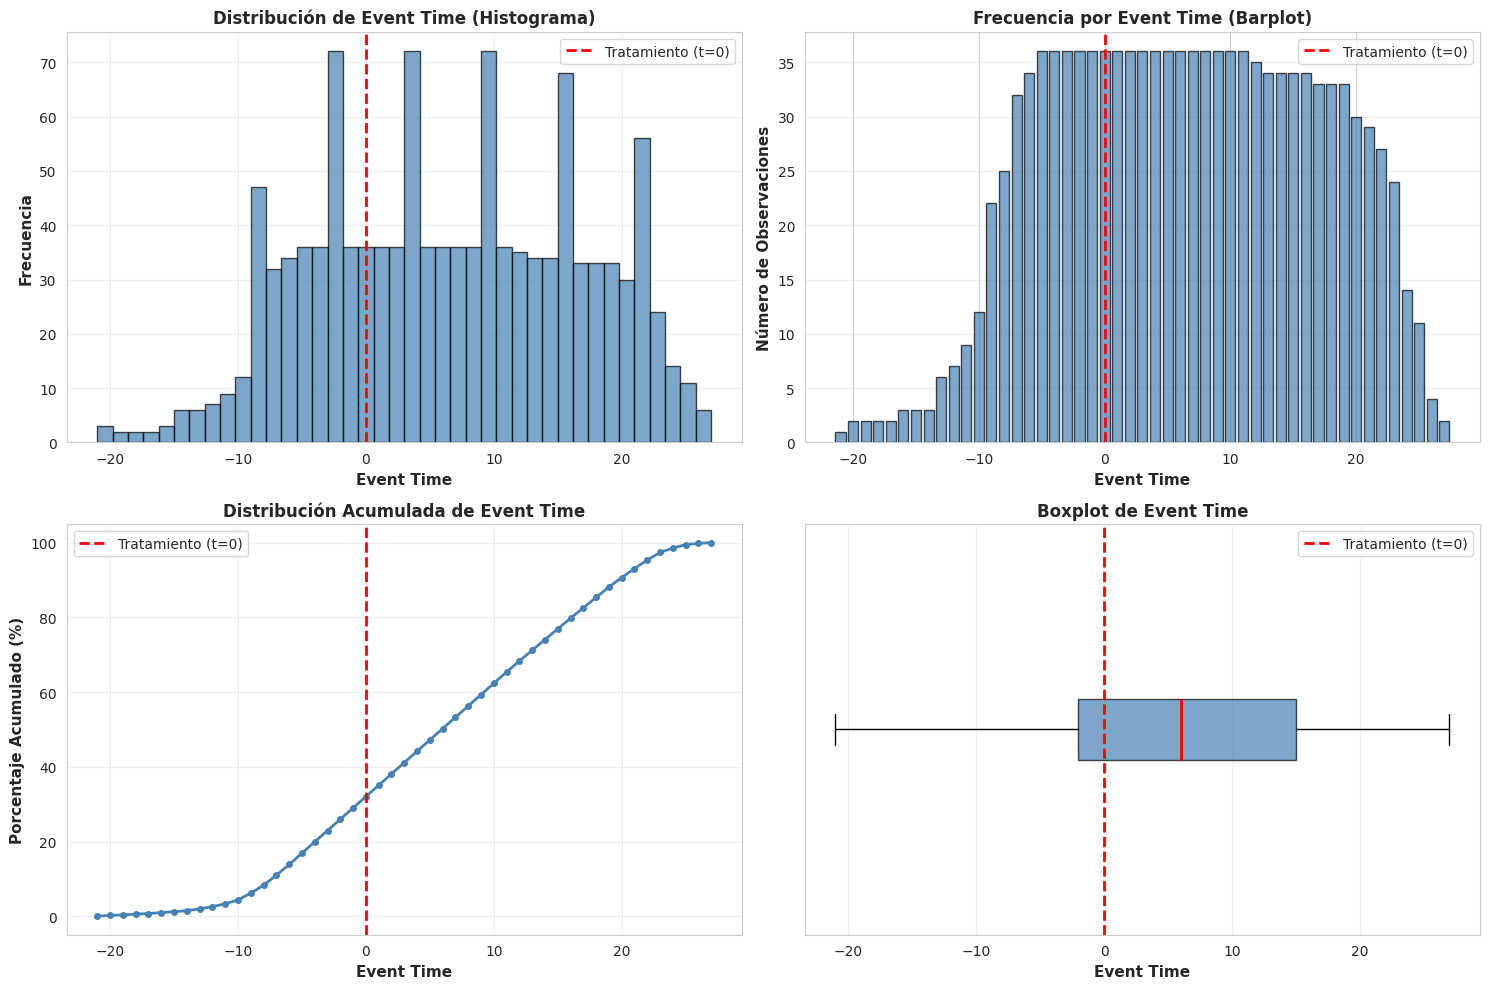


--------------------------------------------------------------------------------
3. ELECCIÓN DE LÍMITES PARA AGRUPAR EVENT TIMES EXTREMOS
--------------------------------------------------------------------------------

ANÁLISIS DE LA DISTRIBUCIÓN:
   Rango completo: [-21, 27]
   Cuartil 25%: -2.0
   Cuartil 75%: 15.0
   Rango intercuartílico (IQR): 17.0

OBSERVACIONES EN LAS COLAS:
   COLA IZQUIERDA (Pre-tratamiento lejano):
     Event time <= -15:    15 obs ( 1.26%)
     Event time <= -10:    52 obs ( 4.38%)
     Event time <=  -7:   131 obs (11.03%)
     Event time <=  -5:   201 obs (16.92%)

   COLA DERECHA (Post-tratamiento lejano):
     Event time >=   5:   663 obs (55.81%)
     Event time >=  10:   483 obs (40.66%)
     Event time >=  15:   308 obs (25.93%)
     Event time >=  20:   141 obs (11.87%)

   Observaciones en ventana [-5, 5]: 396 (33.3%)

   Observaciones en ventana [-7, 7]: 534 (44.9%)

   Observaciones en ventana [-10, 10]: 701 (59.0%)

>>> LÍMITES ELEGIDOS: [-5, 5

In [7]:
# ============================================================================
# PARTE B: PREPARACIÓN PARA EVENT-STUDY
# ============================================================================
print("\n\n" + "="*80)
print("PARTE B: PREPARACIÓN PARA EVENT-STUDY")
print("="*80)

# 1. CREAR VARIABLE DE TIEMPO RELATIVO
print("\n" + "-"*80)
print("1. CREACIÓN DE VARIABLE DE TIEMPO RELATIVO (EVENT TIME)")
print("-"*80)

# Event time = year - treatment year (_nfd)
# Para estados nunca tratados, asignar un valor especial (-1000)
df['event_time'] = np.where(
    df['_nfd'].notna(),
    df['year'] - df['_nfd'],
    -1000  # Indicador para estados nunca tratados
)

print("\n✓ Variable 'event_time' creada")
print("\nEvent Time = Año Actual - Año de Tratamiento (_nfd)")
print("  - event_time = -3 significa 3 años ANTES del tratamiento")
print("  - event_time = 0 significa el año DEL tratamiento")
print("  - event_time = 2 significa 2 años DESPUÉS del tratamiento")
print("  - event_time = -1000 indica estados NUNCA tratados (grupo de control puro)")

print("\nEjemplos de la variable creada:")
print("\nEstado tratado en 1971 (stfips=1):")
print(df[df['stfips']==1][['stfips', 'year', '_nfd', 'event_time', 'treated', 'asmrs']].head(12))
print("\nEstado nunca tratado:")
never_treated_state = df[df['event_time']==-1000]['stfips'].iloc[0]
print(df[df['stfips']==never_treated_state][['stfips', 'year', '_nfd', 'event_time', 'treated', 'asmrs']].head(8))


# 2. TABLA DE FRECUENCIAS
print("\n" + "-"*80)
print("2. TABLA DE FRECUENCIAS DE EVENT TIME")
print("-"*80)

# Filtrar solo estados tratados para el análisis
df_treated = df[df['event_time'] != -1000].copy()
print(f"\nObservaciones de estados tratados: {len(df_treated)}")
print(f"Observaciones de estados nunca tratados: {len(df) - len(df_treated)}")

# Tabla de frecuencias
freq_table = df_treated['event_time'].value_counts().sort_index()
print("\nFRECUENCIA DE CADA EVENT TIME:")
print("="*50)
freq_df = pd.DataFrame({
    'Event Time': freq_table.index,
    'Frecuencia': freq_table.values,
    'Porcentaje': (freq_table.values / len(df_treated) * 100).round(2)
})
print(freq_df.to_string(index=False))

# Estadísticas descriptivas
print("\n" + "="*50)
print("ESTADÍSTICAS DESCRIPTIVAS:")
print("="*50)
stats_dict = {
    'Mínimo': df_treated['event_time'].min(),
    'Cuartil 25%': df_treated['event_time'].quantile(0.25),
    'Mediana': df_treated['event_time'].median(),
    'Media': df_treated['event_time'].mean(),
    'Cuartil 75%': df_treated['event_time'].quantile(0.75),
    'Máximo': df_treated['event_time'].max(),
    'Desviación estándar': df_treated['event_time'].std()
}
for key, value in stats_dict.items():
    print(f"{key:.<30} {value:.2f}")

# Visualización de la distribución
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma
axes[0, 0].hist(df_treated['event_time'], bins=40, edgecolor='black',
                alpha=0.7, color='steelblue')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2,
                   label='Tratamiento (t=0)')
axes[0, 0].set_xlabel('Event Time', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Distribución de Event Time (Histograma)',
                     fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Barplot detallado
axes[0, 1].bar(freq_table.index, freq_table.values, edgecolor='black',
               alpha=0.7, color='steelblue')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2,
                   label='Tratamiento (t=0)')
axes[0, 1].set_xlabel('Event Time', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Número de Observaciones', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Frecuencia por Event Time (Barplot)',
                     fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Distribución acumulada
cumsum_freq = freq_table.sort_index().cumsum()
cumsum_pct = (cumsum_freq / len(df_treated) * 100)
axes[1, 0].plot(cumsum_pct.index, cumsum_pct.values, marker='o',
                linewidth=2, markersize=4, color='steelblue')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2,
                   label='Tratamiento (t=0)')
axes[1, 0].set_xlabel('Event Time', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Porcentaje Acumulado (%)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Distribución Acumulada de Event Time',
                     fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Boxplot
axes[1, 1].boxplot([df_treated['event_time']], vert=False,
                   patch_artist=True,
                   boxprops=dict(facecolor='steelblue', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2))
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2,
                   label='Tratamiento (t=0)')
axes[1, 1].set_xlabel('Event Time', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Boxplot de Event Time', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_yticks([])

plt.tight_layout()
plt.savefig('event_time_distribution.png', dpi=300, bbox_inches='tight')
print("\n✓ Gráfico guardado: event_time_distribution.png")
plt.show()


# 3. ELECCIÓN DE LÍMITES (BOUNDS)
print("\n" + "-"*80)
print("3. ELECCIÓN DE LÍMITES PARA AGRUPAR EVENT TIMES EXTREMOS")
print("-"*80)

min_event = int(df_treated['event_time'].min())
max_event = int(df_treated['event_time'].max())
q25 = df_treated['event_time'].quantile(0.25)
q75 = df_treated['event_time'].quantile(0.75)

print(f"\nANÁLISIS DE LA DISTRIBUCIÓN:")
print(f"   Rango completo: [{min_event}, {max_event}]")
print(f"   Cuartil 25%: {q25:.1f}")
print(f"   Cuartil 75%: {q75:.1f}")
print(f"   Rango intercuartílico (IQR): {q75 - q25:.1f}")

# Analizar colas de la distribución
print("\nOBSERVACIONES EN LAS COLAS:")
print("   " + "="*60)
print("   COLA IZQUIERDA (Pre-tratamiento lejano):")
for threshold in [-15, -10, -7, -5]:
    count = (df_treated['event_time'] <= threshold).sum()
    pct = 100 * count / len(df_treated)
    print(f"     Event time <= {threshold:3d}: {count:5d} obs ({pct:5.2f}%)")

print("\n   COLA DERECHA (Post-tratamiento lejano):")
for threshold in [5, 10, 15, 20]:
    count = (df_treated['event_time'] >= threshold).sum()
    pct = 100 * count / len(df_treated)
    print(f"     Event time >= {threshold:3d}: {count:5d} obs ({pct:5.2f}%)")

# Contar observaciones en ventana central
for window in [5, 7, 10]:
    count_window = ((df_treated['event_time'] >= -window) &
                   (df_treated['event_time'] <= window)).sum()
    pct_window = 100 * count_window / len(df_treated)
    print(f"\n   Observaciones en ventana [-{window}, {window}]: {count_window} ({pct_window:.1f}%)")

# Elegir bounds razonables
lower_bound = -5
upper_bound = 5

print(f"\n" + "="*70)
print(f">>> LÍMITES ELEGIDOS: [{lower_bound}, {upper_bound}]")
print("="*70)
obs_in_window = ((df_treated['event_time'] >= lower_bound) & (df_treated['event_time'] <= upper_bound)).sum()
pct_in_window = 100 * obs_in_window / len(df_treated)
print(f"""
JUSTIFICACIÓN:
- Captura {obs_in_window} observaciones ({pct_in_window:.1f}% de los datos tratados)
- Balancea la precisión de estimación con suficientes observaciones
- Ventana simétrica alrededor del tratamiento
- Incluye periodos pre y post más relevantes para análisis de políticas
""")


# 4. RESPONDER PREGUNTA TEÓRICA
print("\n" + "="*80)
print("4. ¿POR QUÉ AGRUPAMOS EVENT TIMES MUY DISTANTES?")
print("="*80)
print("""
RAZONES PRINCIPALES PARA AGRUPAR LOS EVENT TIMES EXTREMOS:

1. POCAS OBSERVACIONES
   - Los event times muy lejanos (ej. t=-20 o t=15) tienen pocas observaciones
   - Esto genera estimadores IMPRECISOS con errores estándar muy grandes
   - Agrupar aumenta el tamaño de muestra y mejora la precisión

2. PROBLEMAS DE IDENTIFICACIÓN
   - En los extremos temporales puede haber confusión entre:
     * Efectos del tiempo calendario (time fixed effects)
     * Efectos del tratamiento
   - Esto dificulta aislar el efecto causal del tratamiento

3. SUPUESTO DE TENDENCIAS PARALELAS
   - El supuesto clave de DiD es que tratados y controles tendrían
     la misma tendencia en ausencia de tratamiento
   - Este supuesto es MÁS CREÍBLE en ventanas cercanas al tratamiento
   - En periodos muy distantes, otras variables no observadas pueden
     afectar el outcome de manera diferencial

4. EFICIENCIA ESTADÍSTICA
   - Agrupar reduce el número de parámetros a estimar
   - Esto aumenta los grados de libertad y la potencia estadística
   - Mejora la estabilidad numérica de las estimaciones

5. INTERPRETABILIDAD Y RELEVANCIA
   - Los efectos inmediatos pre/post tratamiento son más relevantes
     para política pública que efectos 20 años antes/después
   - Facilita la comunicación de resultados a audiencias no técnicas
   - Enfoca el análisis en la ventana de interés sustantivo

6. COLINEALIDAD
   - Con muchos dummies de event-time, puede haber problemas de
     colinealidad con los fixed effects de tiempo
   - Agrupar reduce este problema

PRÁCTICA COMÚN:
- Agrupar todo lo anterior a t=-5 en una sola categoría: "<=-5"
- Agrupar todo lo posterior a t=5 en una sola categoría: ">=5"
- Omitir t=-1 como categoría de referencia (pre-tratamiento inmediato)
""")


# 5. CREAR DUMMIES DE TIEMPO RELATIVO
print("\n" + "="*80)
print("5. CREACIÓN DE DUMMIES DE TIEMPO RELATIVO")
print("="*80)

# Crear event_time_binned en TODO el dataframe (no solo en df_treated)
df['event_time_binned'] = df['event_time'].copy()
df.loc[df['event_time'] < lower_bound, 'event_time_binned'] = lower_bound
df.loc[df['event_time'] > upper_bound, 'event_time_binned'] = upper_bound

print(f"\n✓ Event times extremos agrupados:")
print(f"   - Todos los t < {lower_bound} -> agrupados en t={lower_bound}")
print(f"   - Todos los t > {upper_bound} -> agrupados en t={upper_bound}")

# Obtener los event times únicos (excluyendo -1 como referencia y -1000 para nunca tratados)
event_times = sorted([t for t in df['event_time_binned'].unique() if t != -1 and t != -1000])

print(f"\n✓ Categorías de event_time después de agrupar:")
print(f"   {event_times}")
print(f"\n✓ Periodo de referencia (omitido): t = -1")
print(f"   (Un periodo antes del tratamiento)")

# Crear dummies para cada event time
print(f"\nCreando {len(event_times)} variables dummy...")
for t in event_times:
    dummy_name = f'event_time_{int(t)}'
    # La dummy es 1 si: event_time_binned == t AND el estado es tratado
    df[dummy_name] = ((df['event_time_binned'] == t) &
                      (df['event_time'] != -1000)).astype(int)

dummy_cols = [f'event_time_{int(t)}' for t in event_times]
print(f"✓ Variables dummy creadas: {len(dummy_cols)}")
print(f"  Nombres: {', '.join(dummy_cols)}")

# Verificar creación de dummies
print("\n" + "-"*80)
print("VERIFICACIÓN DE DUMMIES CREADAS")
print("-"*80)
dummy_summary = df[dummy_cols].sum().sort_index()
print("\nNúmero de observaciones con valor 1 en cada dummy:")
for col in dummy_cols:
    count = df[col].sum()
    print(f"  {col:20s}: {count:5.0f} observaciones")

# Verificar que cada observación tratada tiene exactamente una dummy=1
treated_obs = df[df['event_time'] != -1000]
dummy_sum_per_obs = treated_obs[dummy_cols].sum(axis=1)
print(f"\n✓ Verificación: Cada observación tratada (excluyendo t=-1) debe tener")
print(f"  exactamente una dummy=1:")
print(f"  - Observaciones con 1 dummy activa: {(dummy_sum_per_obs == 1).sum()}")
print(f"  - Observaciones con 0 dummies (t=-1 o nunca tratados): {(dummy_sum_per_obs == 0).sum()}")

# Visualizar matriz de dummies (muestra)
print("\n" + "-"*80)
print("MUESTRA DE DATOS CON DUMMIES (Estado 1)")
print("-"*80)
sample_cols = ['stfips', 'year', 'event_time', 'event_time_binned', 'treated'] + dummy_cols[:5]
print(df[df['stfips']==1][sample_cols].head(15).to_string())

# Guardar dataset procesado
output_file = 'bacon_data_processed.csv'
df.to_csv(output_file, index=False)
print(f"\n✓ Dataset procesado guardado: {output_file}")
print(f"  Tamaño: {df.shape[0]} filas x {df.shape[1]} columnas")
print(f"  Nuevas variables creadas: event_time, event_time_binned, treated, {len(dummy_cols)} dummies")



PARTE C: EVENT-STUDY ESTIMATION

--------------------------------------------------------------------------------
0. PREPARACIÓN: RENOMBRAR DUMMIES
--------------------------------------------------------------------------------
✓ Variables dummy renombradas:
  Ejemplo: 'event_time_-5' -> 'event_time_m5'
  Ejemplo: 'event_time_3' -> 'event_time_3'

Nuevas columnas: ['event_time_m5', 'event_time_m4', 'event_time_m3', 'event_time_m2', 'event_time_0', 'event_time_1', 'event_time_2', 'event_time_3', 'event_time_4', 'event_time_5']

--------------------------------------------------------------------------------
1. ESTIMACIÓN DEL MODELO EVENT-STUDY
--------------------------------------------------------------------------------

Fórmula del modelo:
asmrs ~ event_time_m5 + event_time_m4 + event_time_m3 + ... + event_time_4 + event_time_5 +
        pcinc + asmrh + cases + C(stfips) + C(year)

Total de dummies de event-time: 10
Periodo de referencia: t = -1 (omitido)
Controles: pcinc, asmrh,

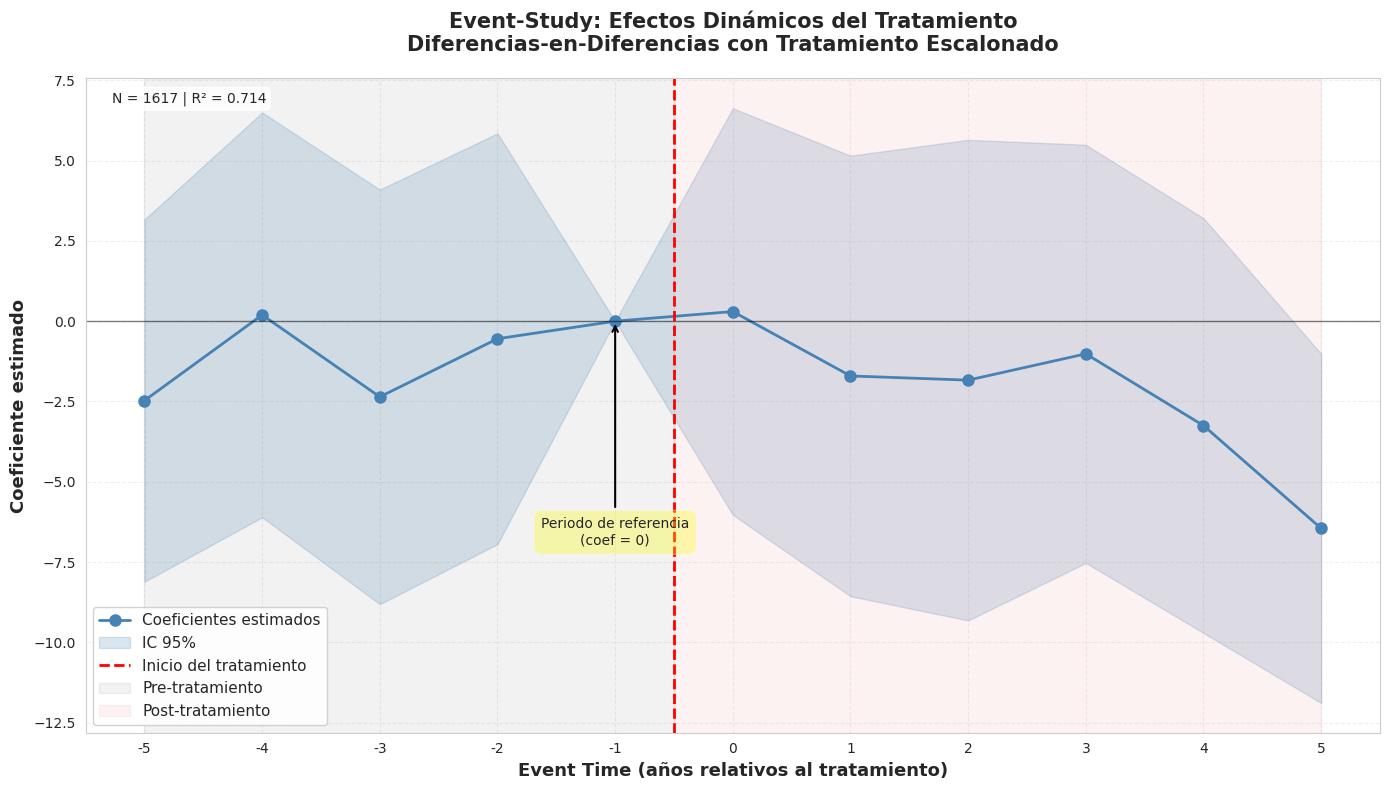


ANÁLISIS DE COEFICIENTES

COEFICIENTES PRE-TRATAMIENTO:
--------------------------------------------------------------------------------
t =  -5:  -2.4713 (2.8766) 
t =  -4:   0.1953 (3.2142) 
t =  -3:  -2.3561 (3.2921) 
t =  -2:  -0.5467 (3.2620) 
t =  -1:   0.0000 (0.0000) 

COEFICIENTES POST-TRATAMIENTO:
--------------------------------------------------------------------------------
t =   0:   0.3001 (3.2292) 
t =   1:  -1.7049 (3.4985) 
t =   2:  -1.8352 (3.8168) 
t =   3:  -1.0168 (3.3205) 
t =   4:  -3.2500 (3.2939) 
t =   5:  -6.4503 (2.7728) **

Nota: *** p<0.01, ** p<0.05, * p<0.10

TEST DE TENDENCIAS PARALELAS (PRE-TRATAMIENTO)

Número de coeficientes pre-tratamiento: 4
Coeficientes significativos al 5%: 0
Proporción significativa: 0.0%

✓ RESULTADO: No se rechaza el supuesto de tendencias paralelas
  Los coeficientes pre-tratamiento no son significativamente diferentes de cero

ANÁLISIS DE EFECTOS POST-TRATAMIENTO

Número de periodos post-tratamiento: 6
Coeficientes signif

In [9]:
# ============================================================================
# PARTE C: EVENT-STUDY ESTIMATION
# ============================================================================
print("\n\n" + "="*80)
print("PARTE C: EVENT-STUDY ESTIMATION")
print("="*80)

# SOLUCIÓN: Renombrar las dummies con números negativos
print("\n" + "-"*80)
print("0. PREPARACIÓN: RENOMBRAR DUMMIES")
print("-"*80)

# Crear diccionario de mapeo para renombrar columnas
rename_dict = {}
for col in dummy_cols:
    # Extraer el número del event_time
    t = int(col.replace('event_time_', ''))
    if t < 0:
        # Reemplazar guión con 'm' (minus)
        new_name = f'event_time_m{abs(t)}'
    else:
        new_name = f'event_time_{t}'
    rename_dict[col] = new_name

# Renombrar columnas en el dataframe
df.rename(columns=rename_dict, inplace=True)

# Actualizar lista de nombres de columnas dummy
dummy_cols_renamed = [rename_dict[col] for col in dummy_cols]

print(f"✓ Variables dummy renombradas:")
print(f"  Ejemplo: 'event_time_-5' -> 'event_time_m5'")
print(f"  Ejemplo: 'event_time_3' -> 'event_time_3'")
print(f"\nNuevas columnas: {dummy_cols_renamed}")


# 1. ESTIMAR MODELO EVENT-STUDY
print("\n" + "-"*80)
print("1. ESTIMACIÓN DEL MODELO EVENT-STUDY")
print("-"*80)

# Construir fórmula del modelo
# Incluye: dummies de event_time + controles + fixed effects
# Omitimos event_time_m1 (periodo de referencia t=-1)
formula_parts = dummy_cols_renamed + ['pcinc', 'asmrh', 'cases', 'C(stfips)', 'C(year)']
formula = 'asmrs ~ ' + ' + '.join(formula_parts)

print("\nFórmula del modelo:")
print(f"asmrs ~ {' + '.join(dummy_cols_renamed[:3])} + ... + {' + '.join(dummy_cols_renamed[-2:])} +")
print(f"        pcinc + asmrh + cases + C(stfips) + C(year)")
print(f"\nTotal de dummies de event-time: {len(dummy_cols_renamed)}")
print(f"Periodo de referencia: t = -1 (omitido)")
print(f"Controles: pcinc, asmrh, cases")
print(f"Fixed effects: stfips (unit), year (time)")

# Estimar modelo con errores estándar robustos (HC1)
print("\nEstimando modelo...")
event_study_model = smf.ols(formula, data=df).fit(cov_type='HC1')
print("✓ Modelo estimado exitosamente")

# Resumen del modelo
print("\n" + "-"*80)
print("RESUMEN DEL MODELO")
print("-"*80)
print(f"N observaciones:     {int(event_study_model.nobs)}")
print(f"R-cuadrado:          {event_study_model.rsquared:.4f}")
print(f"R-cuadrado ajustado: {event_study_model.rsquared_adj:.4f}")
print(f"F-statistic:         {event_study_model.fvalue:.2f}")
print(f"P-valor (F-stat):    {event_study_model.f_pvalue:.6f}")


# 2. ALMACENAR COEFICIENTES Y ERRORES ESTÁNDAR
print("\n" + "-"*80)
print("2. ALMACENAMIENTO DE RESULTADOS")
print("-"*80)

# Extraer coeficientes y errores estándar de las dummies de event_time
coefficients = []
std_errors = []
event_time_values = []

for col in dummy_cols_renamed:
    # Extraer el valor de event_time del nombre de la columna
    if 'event_time_m' in col:
        t = -int(col.replace('event_time_m', ''))
    else:
        t = int(col.replace('event_time_', ''))

    event_time_values.append(t)
    coefficients.append(event_study_model.params[col])
    std_errors.append(event_study_model.bse[col])

# Agregar el punto de referencia (t=-1) con coef=0 y se=0
event_time_values.append(-1)
coefficients.append(0)
std_errors.append(0)

# Crear DataFrame con resultados y ordenar por event_time
results_df = pd.DataFrame({
    'event_time': event_time_values,
    'coefficient': coefficients,
    'std_error': std_errors
})
results_df = results_df.sort_values('event_time').reset_index(drop=True)

# Calcular intervalos de confianza (95%)
z_critical = 1.96
results_df['ci_lower'] = results_df['coefficient'] - z_critical * results_df['std_error']
results_df['ci_upper'] = results_df['coefficient'] + z_critical * results_df['std_error']

# Calcular p-valores y estadístico t
results_df['t_stat'] = results_df['coefficient'] / results_df['std_error']
results_df['p_value'] = 2 * (1 - stats.norm.cdf(np.abs(results_df['t_stat'])))

# Reemplazar valores en t=-1 (referencia)
results_df.loc[results_df['event_time'] == -1, ['t_stat', 'p_value']] = [np.nan, np.nan]

print("✓ Coeficientes y errores estándar almacenados")
print("\nRESULTADOS DEL EVENT-STUDY:")
print("="*80)
print(results_df.to_string(index=False))

# Guardar resultados
results_df.to_csv('event_study_results.csv', index=False)
print("\n✓ Resultados guardados: event_study_results.csv")


# 3. GRAFICAR COEFICIENTES DEL EVENT-STUDY
print("\n" + "-"*80)
print("3. VISUALIZACIÓN DE RESULTADOS")
print("-"*80)

# Crear figura
fig, ax = plt.subplots(figsize=(14, 8))

# Extraer datos para el gráfico
x = results_df['event_time']
y = results_df['coefficient']
ci_lower = results_df['ci_lower']
ci_upper = results_df['ci_upper']

# Graficar coeficientes
ax.plot(x, y, marker='o', linewidth=2, markersize=8,
        color='steelblue', label='Coeficientes estimados')

# Graficar intervalos de confianza
ax.fill_between(x, ci_lower, ci_upper, alpha=0.2, color='steelblue',
                label='IC 95%')

# Línea de referencia en cero
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)

# Línea vertical en el momento del tratamiento
ax.axvline(x=-0.5, color='red', linestyle='--', linewidth=2,
          label='Inicio del tratamiento')

# Sombrear región pre-tratamiento
ax.axvspan(x.min(), -0.5, alpha=0.1, color='gray', label='Pre-tratamiento')

# Sombrear región post-tratamiento
ax.axvspan(-0.5, x.max(), alpha=0.1, color='lightcoral', label='Post-tratamiento')

# Etiquetas y título
ax.set_xlabel('Event Time (años relativos al tratamiento)', fontsize=13, fontweight='bold')
ax.set_ylabel('Coeficiente estimado', fontsize=13, fontweight='bold')
ax.set_title('Event-Study: Efectos Dinámicos del Tratamiento\n' +
            'Diferencias-en-Diferencias con Tratamiento Escalonado',
            fontsize=15, fontweight='bold', pad=20)

# Configurar eje x
ax.set_xticks(x)
ax.set_xticklabels([int(i) for i in x], rotation=0)

# Grid
ax.grid(True, alpha=0.3, linestyle='--')

# Leyenda
ax.legend(loc='best', fontsize=11, framealpha=0.9)

# Anotaciones
# Anotar el periodo de referencia
ref_idx = list(x).index(-1)
ax.annotate('Periodo de referencia\n(coef = 0)',
           xy=(-1, 0),
           xytext=(-1, y.min() - 0.5),
           ha='center',
           fontsize=10,
           bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3),
           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0',
                          color='black', lw=1.5))

# Añadir información adicional
info_text = f"N = {int(event_study_model.nobs)} | R² = {event_study_model.rsquared:.3f}"
ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
       fontsize=10, verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('event_study_plot.png', dpi=300, bbox_inches='tight')
print("\n✓ Gráfico guardado: event_study_plot.png")
plt.show()


# Análisis adicional de los coeficientes
print("\n" + "="*80)
print("ANÁLISIS DE COEFICIENTES")
print("="*80)

# Pre-tratamiento
pre_treat = results_df[results_df['event_time'] < 0]
print("\nCOEFICIENTES PRE-TRATAMIENTO:")
print("-"*80)
for _, row in pre_treat.iterrows():
    sig = ""
    if pd.notna(row['p_value']):
        if row['p_value'] < 0.01:
            sig = "***"
        elif row['p_value'] < 0.05:
            sig = "**"
        elif row['p_value'] < 0.10:
            sig = "*"
    print(f"t = {row['event_time']:3.0f}: {row['coefficient']:8.4f} ({row['std_error']:6.4f}) {sig}")

# Post-tratamiento
post_treat = results_df[results_df['event_time'] >= 0]
print("\nCOEFICIENTES POST-TRATAMIENTO:")
print("-"*80)
for _, row in post_treat.iterrows():
    sig = ""
    if pd.notna(row['p_value']):
        if row['p_value'] < 0.01:
            sig = "***"
        elif row['p_value'] < 0.05:
            sig = "**"
        elif row['p_value'] < 0.10:
            sig = "*"
    print(f"t = {row['event_time']:3.0f}: {row['coefficient']:8.4f} ({row['std_error']:6.4f}) {sig}")

print("\nNota: *** p<0.01, ** p<0.05, * p<0.10")

# Test de pre-tendencias paralelas
print("\n" + "="*80)
print("TEST DE TENDENCIAS PARALELAS (PRE-TRATAMIENTO)")
print("="*80)
pre_treat_no_ref = pre_treat[pre_treat['event_time'] != -1]
n_pre_signif = (pre_treat_no_ref['p_value'] < 0.05).sum()
print(f"\nNúmero de coeficientes pre-tratamiento: {len(pre_treat_no_ref)}")
print(f"Coeficientes significativos al 5%: {n_pre_signif}")
if len(pre_treat_no_ref) > 0:
    print(f"Proporción significativa: {n_pre_signif/len(pre_treat_no_ref)*100:.1f}%")

if n_pre_signif == 0:
    print("\n✓ RESULTADO: No se rechaza el supuesto de tendencias paralelas")
    print("  Los coeficientes pre-tratamiento no son significativamente diferentes de cero")
else:
    print(f"\nADVERTENCIA: {n_pre_signif} coeficiente(s) pre-tratamiento son significativos")
    print("  Esto puede indicar violación del supuesto de tendencias paralelas")

# Análisis de efectos post-tratamiento
print("\n" + "="*80)
print("ANÁLISIS DE EFECTOS POST-TRATAMIENTO")
print("="*80)
post_treat_all = post_treat.copy()
mean_effect = post_treat_all['coefficient'].mean()
n_post_signif = (post_treat_all['p_value'] < 0.05).sum()

print(f"\nNúmero de periodos post-tratamiento: {len(post_treat_all)}")
print(f"Coeficientes significativos al 5%: {n_post_signif}")
print(f"Efecto promedio post-tratamiento: {mean_effect:.4f}")

if n_post_signif > 0:
    print(f"\n✓ Se detectan efectos significativos del tratamiento en {n_post_signif} periodo(s)")
else:
    print("\n! No se detectan efectos significativos del tratamiento")

print("\n" + "="*80)
print("PARTE C COMPLETADA")
print("="*80)
print("\nArchivos generados:")
print("  1. event_study_results.csv - Tabla de coeficientes y estadísticas")
print("  2. event_study_plot.png - Gráfico de event-study")